## Volcano Eruptions data exploration

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

Data was downloaded from https://volcano.si.edu/ on 15 April 2024.

The data was modified according to specified requirements:
- omit rows where eruptions are said to be discredited and also ones, that don't have VEI metric associated with them,
- create columns "Evidence Type" and "Evidence Method" from "Evidence Method (dating)" of the original data
- in the created columns change NaN values for "Uncertain" and "Unspecified" respectively
- remove the word "Eruption" in "Eruption Category" column values

In [2]:
eruptions=pd.read_csv('GVP_Eruption_Results.csv',skiprows=1)
eruptions = eruptions[eruptions['VEI'].notna()]

In [3]:
eruptions[["Evidence Type","Evidence Method"]]=eruptions["Evidence Method (dating)"].str.split(': ',expand=True)
eruptions=eruptions[['Volcano Name', 'Eruption Number', 'Eruption Category', 'VEI', 'Start Year',
                     'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day', "Evidence Type",
                     "Evidence Method"]]
eruptions=eruptions.set_index("Eruption Number")
eruptions=eruptions[eruptions["Eruption Category"]!='Discredited Eruption']
eruptions=eruptions[np.isnan(eruptions["VEI"])!=True]
eruptions['Eruption Category'] = eruptions['Eruption Category'].str.replace(' Eruption',"")
eruptions[['Start Month','Start Day','End Month','End Day']] = eruptions[['Start Month','Start Day',
                                                                          'End Month', 'End Day']].replace(0, float("NaN"))
eruptions['Evidence Method'] = eruptions['Evidence Method'].fillna(value="Unspecified")
eruptions['Evidence Type'] = eruptions['Evidence Type'].fillna(value="Uncertain")
eruptions['VEI'] = eruptions['VEI'].astype(int)
eruptions = eruptions[:-1] #deleting the oldest record because it messes with data visualisation

# Data exploration

This section regards simple data exploration, with focus on extraction interestion statistics such as:
- the biggest eruptions recorded,
- the most ative volcanos,
- year of the last eruption by the VEI metric.

The main focus of the project is the familiarization of frequency distributions metrics and the visalization of the data.

In [4]:
big_eruptions=eruptions[eruptions['VEI']==7]

most_active=eruptions['Volcano Name'].value_counts().to_frame().reset_index()
most_active=most_active.rename(columns={'index':'Volcano','Volcano Name':'Recorded eruptions'})

last_eruption=eruptions.loc[:,['VEI','Start Year','Volcano Name']]
last_eruption=last_eruption.groupby(['VEI'])['Start Year'].max().to_frame().rename(columns={'Start Year':'Last recorded eruption'})

In [5]:
vei=eruptions.loc[:,['VEI','Eruption Category']].sort_values(by=['VEI']).set_index('VEI')

vei_con=vei[vei['Eruption Category']=='Confirmed'].groupby('VEI').count().rename(columns={'Eruption Category':'f'}).astype(int)
vei_con['cf']=vei_con['f'].cumsum().astype(int)
vei_con['rf']=vei_con['f']/vei_con.iloc[-1]['cf']
vei_con['crf']=vei_con['rf'].cumsum()

vei_un=vei[vei['Eruption Category']!='Confirmed'].groupby('VEI').count().rename(columns={'Eruption Category':'f'}).astype(int)
vei_un['cf']=vei_un['f'].cumsum().astype(int)
vei_un['rf']=vei_un['f']/vei_un.iloc[-1]['cf']
vei_un['crf']=vei_un['rf'].cumsum()

vei_all=vei.groupby('VEI').count().rename(columns={'Eruption Category':'f'}).astype(int)
vei_all['cf']=vei_all['f'].cumsum().astype(int)
vei_all['rf']=vei_all['f']/vei_all.iloc[-1]['cf']
vei_all['crf']=vei_all['rf'].cumsum()

labels=('All eruptions', 'Confirmed Eruptions', 'Uncertain Eruptions')
vei_data=pd.concat([vei_all,vei_con,vei_un],axis=1,keys=labels)
vei_data

All eruptions                           Confirmed Eruptions        \
                f    cf        rf       crf                   f    cf   
VEI                                                                     
0            1009  1009  0.121041  0.121041                 802   802   
1            1407  2416  0.168786  0.289827                1246  2048   
2            4009  6425  0.480926  0.770753                3736  5784   
3            1158  7583  0.138916  0.909669                1136  6920   
4             512  8095  0.061420  0.971089                 511  7431   
5             181  8276  0.021713  0.992802                 181  7612   
6              53  8329  0.006358  0.999160                  53  7665   
7               7  8336  0.000840  1.000000                   7  7672   

                        Uncertain Eruptions                             
           rf       crf                   f     cf        rf       crf  
VEI                                                                     
0    0.104536  0.104536               207.0  207.0  0.311747  0.311747  
1    0.162409  0.266945               161.0  368.0  0.242470  0.554217  
2    0.486966  0.753910               273.0  641.0  0.411145  0.965361  
3    0.148071  0.901981                22.0  663.0  0.033133  0.998494  
4    0.066606  0.968587                 1.0  664.0  0.001506  1.000000  
5    0.023592  0.992179                 NaN    NaN       NaN       NaN  
6    0.006908  0.999088                 NaN    NaN       NaN       NaN  
7    0.000912  1.000000                 NaN    NaN       NaN       NaN

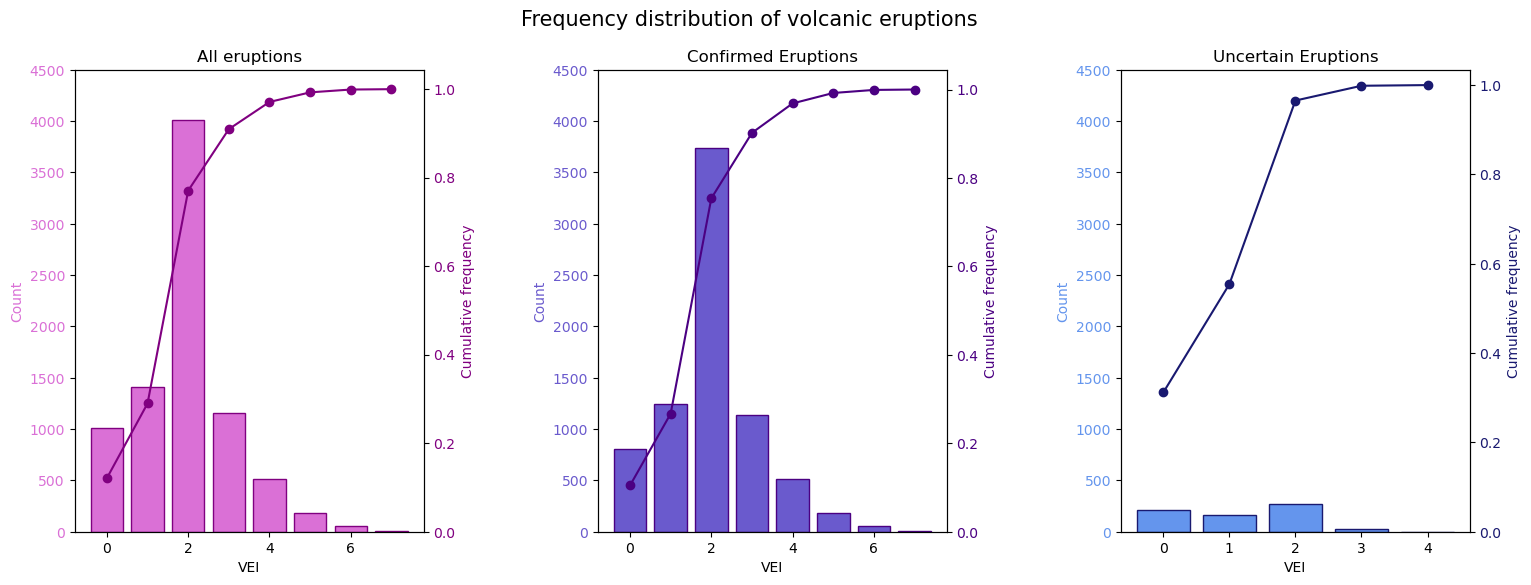

In [6]:
colors = ['orchid','slateblue','cornflowerblue','purple','indigo','midnightblue']

fig, ax=plt.subplots(1,3,figsize=(18,6))
fig.set_facecolor("white")
fig.suptitle("Frequency distribution of volcanic eruptions", fontsize=15)
plt.subplots_adjust(wspace=0.5)
for i in range(len(labels)):
    ax[i].bar(vei_data[labels[i]].index, vei_data[labels[i]]['f'], color=colors[i], edgecolor=colors[i+3], linewidth=1)
    ax[i].set_title(labels[i])
    ax[i].set_xlabel('VEI')
    ax[i].set_ylabel('Count', color=colors[i])
    ax[i].tick_params(axis='y', labelcolor=colors[i])
    ax[i].set_ylim(0,4500)
for i in range(len(labels)):
    ax0 = ax[i].twinx()
    ax0.plot(vei_data[labels[i]].index, vei_data[labels[i]]['crf'], color=colors[i+3], marker='o')
    ax0.set_ylabel('Cumulative frequency', color=colors[i+3])
    ax0.tick_params(axis='y', labelcolor=colors[i+3])
    ax0.set_ylim(0)

In [7]:
vei = eruptions['VEI']
vei_vals, vei_counts = np.unique(vei, return_counts=True)
ev_types = np.unique(eruptions['Evidence Type'])
ev_methods = np.unique(eruptions['Evidence Method'])
indeksy = []
for i in ev_types:
    b = np.unique(eruptions['Evidence Method'].where(eruptions['Evidence Type']==i).dropna())
    indeksy.extend(list(map(lambda e: (i, e), b)))
indeksy = pd.MultiIndex.from_tuples(indeksy, names=["Evidence Type", "Evidence Method"])
evidence_data = pd.DataFrame(columns=vei_vals)
alls = []
for i in indeksy:
    all_vei, counts = np.unique(eruptions['VEI'].where(eruptions['Evidence Type']==i[0]).where(eruptions['Evidence Method']==i[1]).dropna(),return_counts=True)
    alls.append(sum(counts))
    counts = map(lambda x:[x], counts)
    res = dict(zip(all_vei, counts))
    vals = pd.DataFrame(res)
    evidence_data = pd.concat([evidence_data,vals])
evidence_data["All"]=alls
evidence_data.set_index(indeksy,inplace=True)
evidence_data=evidence_data.fillna(0)
evidence_data

0.0   1.0   2.0  3.0  4.0  5.0  6.0  7.0  \
Evidence Type Evidence Method                                                  
Correlation   Anthropology            5     1     6    2    6    1    0    0   
              Magnetism              34     0     5    0    2    0    0    0   
              Tephrochronology       71    16   122  124  103   22    5    0   
Isotopic      14C (calibrated)       41    12    49  101  105   71   21    3   
              14C (uncalibrated)    125     7    34   55   91   41   19    1   
              Ar/Ar                  12     1     0    0    1    1    0    0   
              Cosmic Ray Exposure    20     1     0    0    1    0    0    0   
              K/Ar                   10     0     0    1    0    0    0    0   
              Uranium-series         24     0     0    0    0    0    0    0   
Observations  Aviation                0     4     0    0    0    0    0    0   
              Hydrophonic            68     3     1    0    0    0    0    0   
              Photo / Video           1     1     1    0    0    0    0    0   
              Reported              378  1217  3444  841  194   42    7    1   
              Satellite (infrared)    2     0     3    1    1    0    0    0   
              Satellite (visual)      1     3     2    1    0    0    0    0   
              Seismicity             15     2     1    0    0    0    0    0   
Radiogenic    Fission track           0     0     0    1    0    0    0    0   
              Thermoluminescence      1     0     0    0    1    0    0    0   
Sidereal      Dendrochronology        0     0     0    1    2    3    0    0   
              Ice Core                0     0     3    0    3    0    1    2   
              Varve Count             0     1    66    8    1    0    0    0   
Uncertain     Unspecified           201   138   272   22    1    0    0    0   

                                     All  
Evidence Type Evidence Method             
Correlation   Anthropology            21  
              Magnetism               41  
              Tephrochronology       463  
Isotopic      14C (calibrated)       403  
              14C (uncalibrated)     373  
              Ar/Ar                   15  
              Cosmic Ray Exposure     22  
              K/Ar                    11  
              Uranium-series          24  
Observations  Aviation                 4  
              Hydrophonic             72  
              Photo / Video            3  
              Reported              6124  
              Satellite (infrared)     7  
              Satellite (visual)       7  
              Seismicity              18  
Radiogenic    Fission track            1  
              Thermoluminescence       2  
Sidereal      Dendrochronology         6  
              Ice Core                 9  
              Varve Count             76  
Uncertain     Unspecified            634

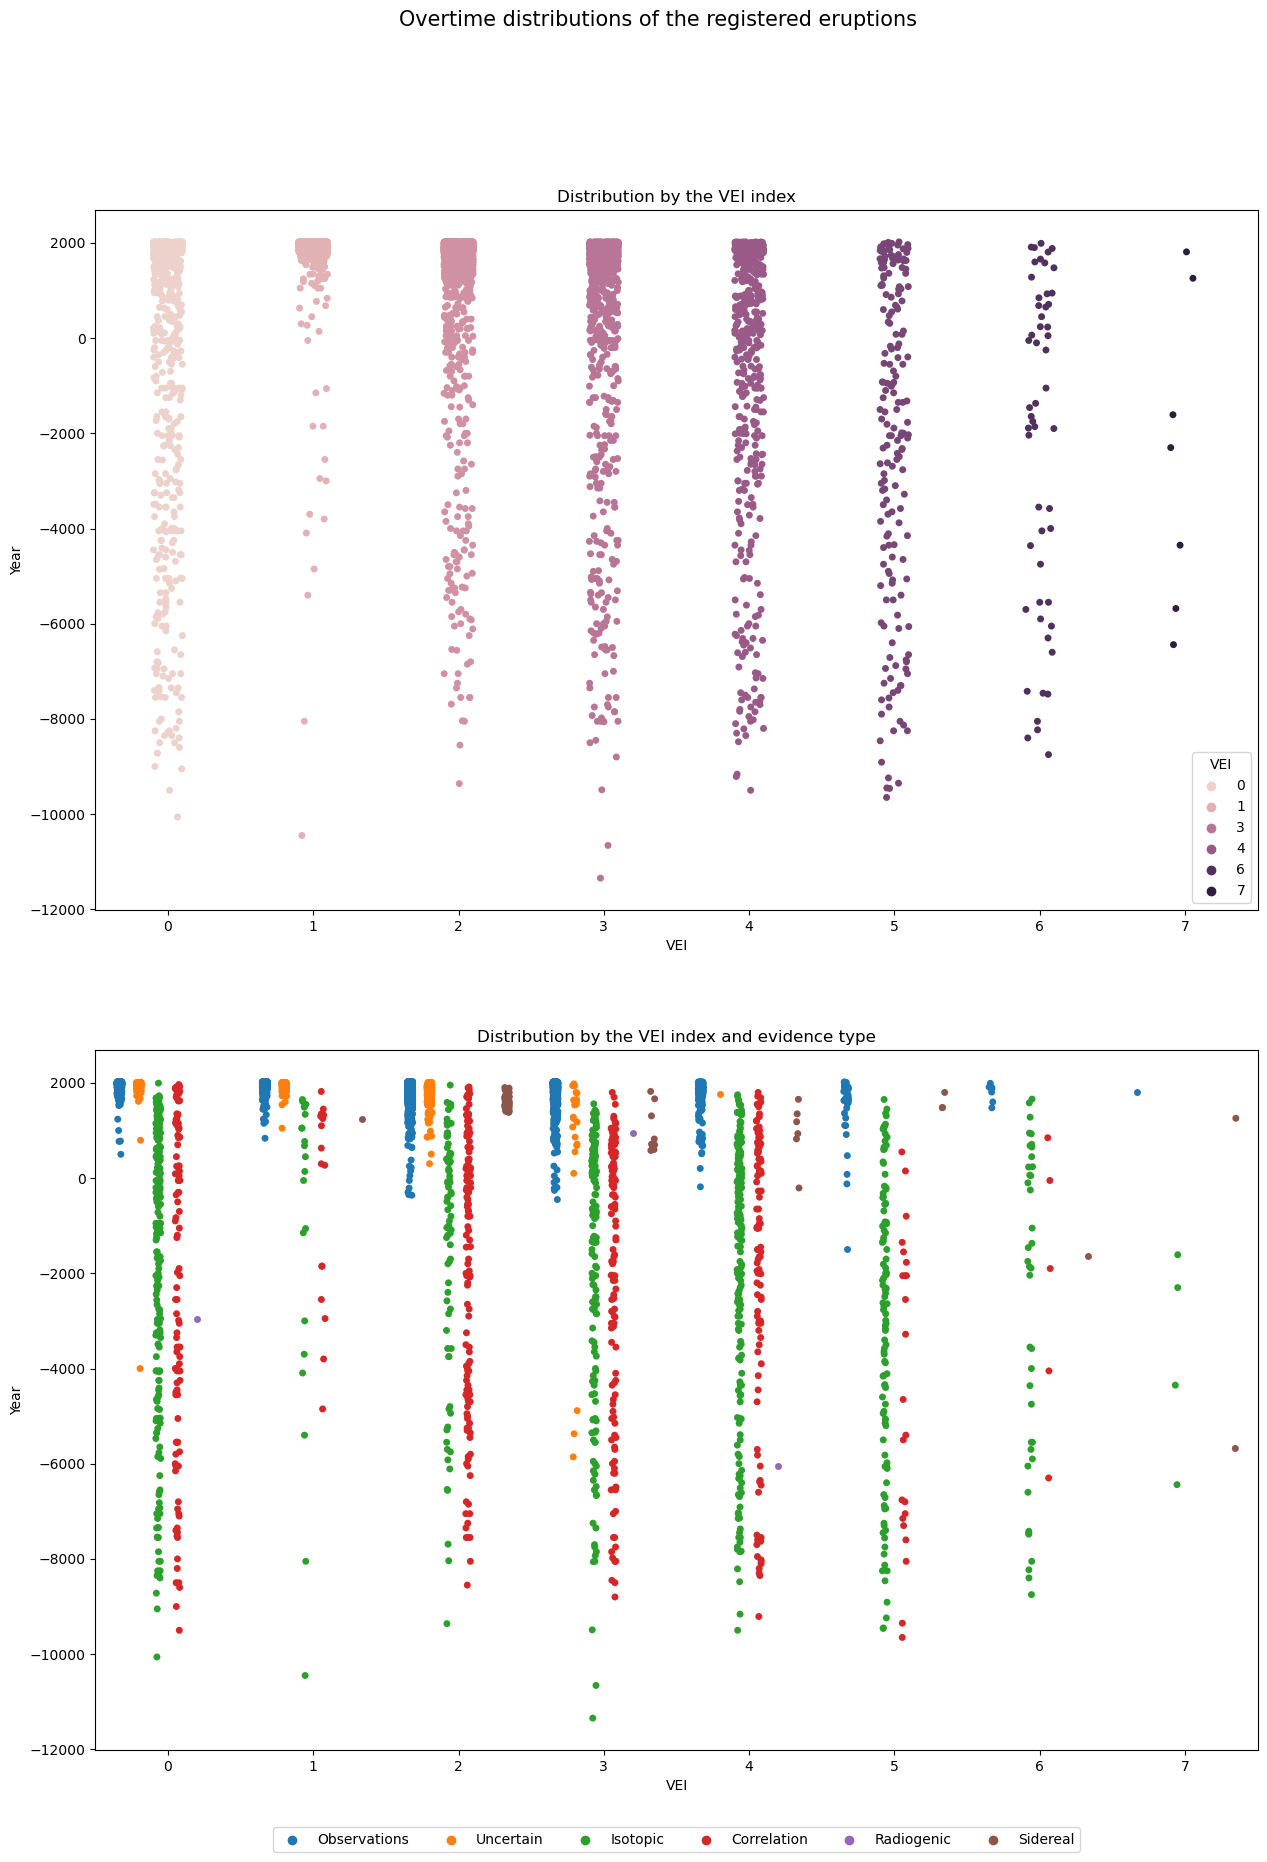

In [8]:
fig, ax=plt.subplots(2,1,figsize=(15,20))
fig.set_facecolor("white")
fig.suptitle("Overtime distributions of the registered eruptions", fontsize=15)
plt.subplots_adjust(wspace=0.5)
sns.stripplot(data=eruptions,x='VEI',y='Start Year',hue="VEI",ax=ax[0])
ax[0].set_title('Distribution by the VEI index')
ax[0].set_ylabel('Year')
ax[0].xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
sns.stripplot(data=eruptions,x='VEI',y='Start Year',hue='Evidence Type',ax=ax[1],dodge=True)
ax[1].set_title('Distribution by the VEI index and evidence type')
ax[1].set_ylabel('Year')
ax[1].xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6);